In [27]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from scipy import signal
from sklearn.linear_model import LinearRegression

import os
from datetime import datetime, timedelta

mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

In [9]:
def correct_angles(data):
    correction = 0  # This variable will store the accumulated correction value
    
    for i in range(1, len(data)):
        difference = data[i] - data[i-1]
        
        # If jump from ~360 to 0
        if difference < -180:
            correction += 360
            
        # If jump from ~0 to 360
        elif difference > 180:
            correction -= 360
        
        # Apply correction
        data[i] += correction

    return data

def round_and_avoid_duplicates(data):
    # Round to the nearest 10
    rounded = np.rint(data / 10.0) * 10
    
    # For each unique element, calculate its adjusted value
    output = np.zeros_like(rounded)
    unique_vals, counts = np.unique(rounded, return_counts=True)
    
    for val, count in zip(unique_vals, counts):
        indices = np.where(rounded == val)[0]
        adjustments = np.arange(count) * 10
        output[indices] = val + adjustments

    return output

def linear_regression_detrend(y):
    """
    Uses linear regression to detrend the data.
    Returns the detrended data.
    """
    X = np.arange(len(y)).reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    
    # Predicted trend
    trend = model.predict(X)
    
    # Detrended data
    detrended = y - trend
    return detrended
    
def normalize_to_range(data, a=-1, b=1):
    X_min = np.min(data)
    X_max = np.max(data)
    
    normalized_data = a + (data - X_min) * (b - a) / (X_max - X_min)
    
    return normalized_data

def filename_to_datetime(filename):
    """
    Converts the filename convention to a datetime object.
    """
    # Remove the file extension and split into components
    components = filename.split('.')[0].split('-')
    month, day, hour, minute, second = map(int, components)
    
    current_year = datetime.now().year
    dt = datetime(current_year, month, day, hour, minute, second)
    return dt

def read_and_adjust_timestamps(directory, filename):
    """
    Reads the file and adjusts the timestamps based on the filename.
    """
    path = os.path.join(directory, filename)
    data = pd.read_csv(path, skiprows=1, delimiter='\t', header=None).to_numpy()

    initial_dt = filename_to_datetime(filename)
    # Adjust timestamps using timedelta
    adjusted_timestamps = [initial_dt + timedelta(seconds=float(t/1000)) for t in (data[:, 0]-data[0, 0])]
    
    return adjusted_timestamps, data[:, 1:]

def concatenate_files(directory):
    """
    Loops over files in directory, adjusts their timestamps, and concatenates them.
    """
    all_timestamps = []
    all_data = []

    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.txt'):
            timestamps, data = read_and_adjust_timestamps(directory, filename)
            all_timestamps.extend(timestamps)
            all_data.extend(data)

    all_data = np.array(all_data)
    y = all_data[:, 0]
    p = all_data[:, 1]
    r = all_data[:, 2]

    return all_timestamps, y, p, r


In [14]:
directory = '../dataset/orientation/test'
paths = os.listdir(directory)

path = paths[0]
data = pd.read_csv(os.path.join(directory, path),
                    skiprows=1,
                    delimiter='\t',
                    header=None).to_numpy()
timestamp = data[:, 0]-data[0, 0]
# timestamp = np.around(timestamp)
timestamp = round_and_avoid_duplicates(timestamp)
# y = data[:, 1]
# p = data[:, 2]
# r = data[:, 3]

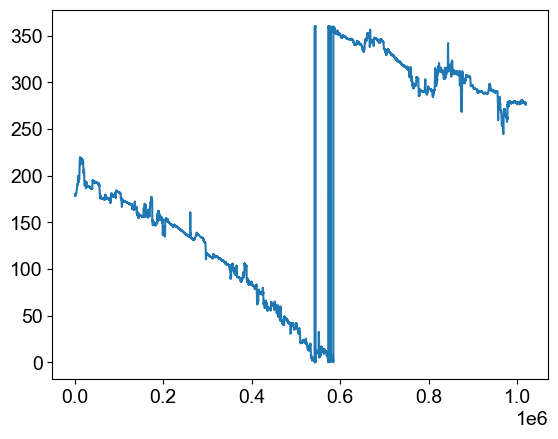

In [7]:
# sos = signal.butter(3, 1, btype='highpass', output='sos', fs=100)
# y_f = signal.sosfilt(sos, y)
# y_dt = moving_difference_detrend(y, window=3)
y_n = normalize_to_range(y)
p_n = normalize_to_range(p)
r_n = normalize_to_range(r)

plt.plot(timestamp, y)
# plt.plot(timestamp, p_n)
# plt.plot(timestamp, r_n)
# plt.xlim(0, 100000)
# plt.ylim(-1, 1)

In [20]:
timestamps, y, p, r = concatenate_files(directory)

timestamp_or = [(ts - timestamps[0]).total_seconds() for ts in timestamps]
timestamp_or = np.array(np.around(timestamps_s, 2))

y_c = correct_angles(y)

y_n = normalize_to_range(y_c)
p_n = normalize_to_range(p)
r_n = normalize_to_range(r)

PV

In [5]:
filename = '../dataset/pv/20230706/long_test_0713_no_comment.txt'
data = pd.read_csv(filename,
                   skiprows=6,
                   delimiter='\t',
                   header=None,
                   comment='#').to_numpy()
timestamp_pv = data[:, 0]
c = data[:, 1]
b = data[:, 2]
tl = data[:, 3]
tr = data[:, 4]

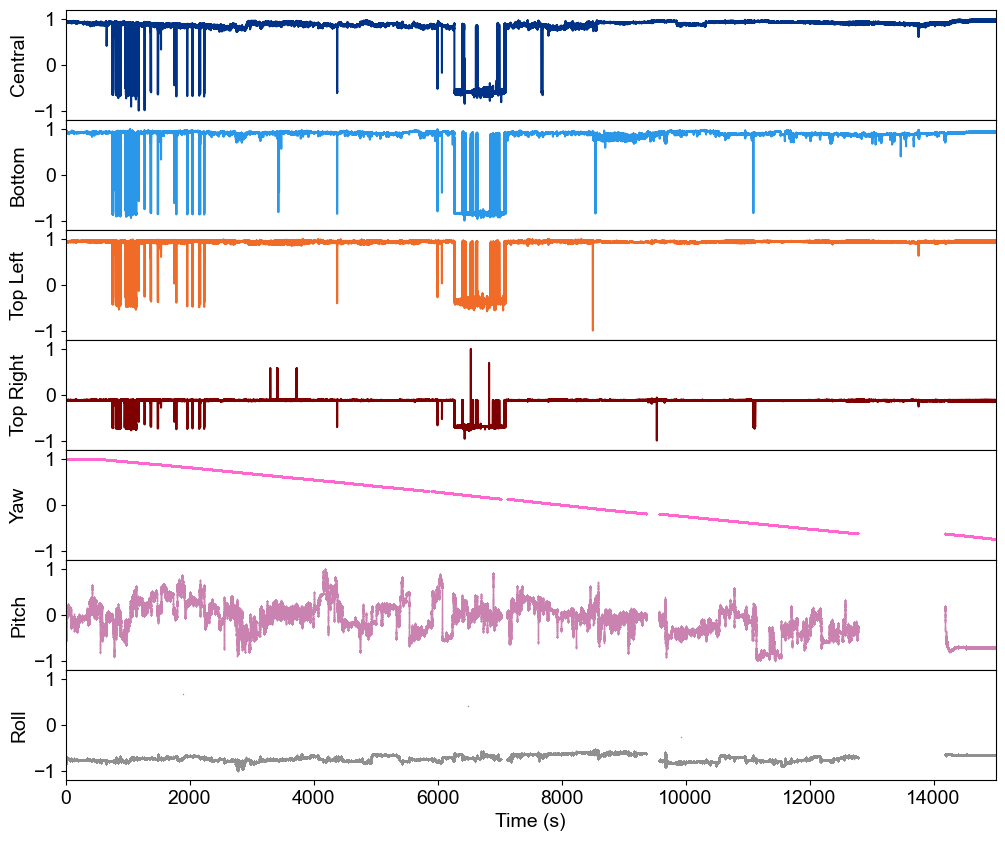

In [33]:
pv_color = ['#003388', '#2a97e9', '#f06a28', '#7e0000']
or_color = ['#ff66d0', '#ca82b0', '#909090']
labels = ['Central', 'Bottom', 'Top Left', 'Top Right', 'Yaw', 'Pitch', 'Roll']

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=[12, 10], sharex=True, sharey=True)
axes[0].plot(timestamp_pv, normalize_to_range(c), c=pv_color[0])
axes[1].plot(timestamp_pv, normalize_to_range(b), c=pv_color[1])
axes[2].plot(timestamp_pv, normalize_to_range(tl), c=pv_color[2])
axes[3].plot(timestamp_pv, normalize_to_range(tr), c=pv_color[3])

axes[4].plot(timestamp_or, y_n, linestyle='None', marker='o', markerfacecolor=or_color[0], mew=0, ms=1)
axes[5].plot(timestamp_or, p_n, linestyle='None', marker='o', markerfacecolor=or_color[1], mew=0, ms=1)
axes[6].plot(timestamp_or, r_n, linestyle='None', marker='o', markerfacecolor=or_color[2], mew=0, ms=1)

# for ax in axes[:-1]:
#     ax.set_xticklabels([])

for ii, ax in enumerate(axes):
    ax.set_ylim([-1.2, 1.2])
    ax.set_ylabel(labels[ii])

axes[-1].set_xlim([0, 15000])
axes[-1].set_xlabel('Time (s)')
fig.subplots_adjust(hspace=0)

plt.savefig('../results/fig5/long_test_result.png')
plt.show()